In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# gridsearch on normal replay buffer
# switch prob A and B back
# Add replay buffer size as experiment axis
# Find Q* and compare with Q values from network

In [72]:
import os, sys

# Add to path the parent directory of this notebook dir

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)

import yaml
import pandas as pd
import torch
import logging


import numpy as np
from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.simple_dqn_agent import AgentDQN


from common.src.visualize import draw_simple_gridworld

from common.src.utils import create_random_policy, extract_V_from_Q_for_stochastic_policy, extract_V_from_Q, derive_policy_from_q_table
from common.src.policy_iteration import random_policy_evaluation_q_stochastic, policy_evaluation_v
from common.src.value_iteration import value_iteration_v, value_iteration_q
 

from common.src.distribution_src import ( 
                                         make_env, 
                                         random_select_starting_pos,
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment,
                                        compute_validation_bellmans_error,
                                        setup_dqn_agent,
                                        run_dqn_distribution_correction_experiment
                                        )

from common.src.experiment_utils import (
    setup_logger
)

In [55]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))


def generic_constructor(loader, tag_suffix, node):
    if isinstance(node, yaml.MappingNode):
        # Attempt to handle unhashable keys by converting them to a string representation
        # This is a workaround and might need adjustment based on specific use cases
        return {
            str(loader.construct_object(key)): loader.construct_object(value)
            for key, value in node.value
        }
    elif isinstance(node, yaml.SequenceNode):
        return [loader.construct_object(child) for child in node.value]
    elif isinstance(node, yaml.ScalarNode):
        return loader.construct_scalar(node)


yaml.SafeLoader.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)
yaml.SafeLoader.add_multi_constructor("", generic_constructor)

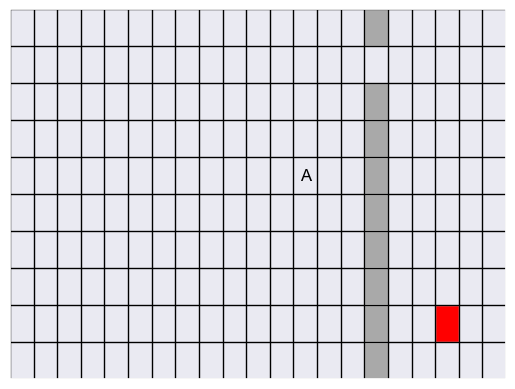

In [56]:
terminal_states = {(8, 18): 1}
start_state = (6, 1)
rows = 10
cols = 21
seed = 2
episode_limit = None
# episode_limit = 400

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = {(0, 15),
 (2, 15),
 (3, 15),
 (4, 15),
 (5, 15),
 (6, 15),
 (7, 15),
 (8, 15),
 (9, 15)}
# random_walls = set()

# print(random_walls)
env = make_env(
    rows,
    cols,
    start_state=start_state,
    p_success=1,
    terminal_states=terminal_states,
    seed=seed,
    walls=random_walls,
    episode_length_limit=episode_limit,
    standardize_wrapper=False,
    randomize_starting_position=True,
    random_stating_positions_parameters={"prob": 1,
                                         "space_A": ((0, 0), (9, 14)),
                                         "space_B": ((0, 16), (5, 20))},
)
env.render()

Optimal Policy: {(6, 18): <Action.DOWN: 2>, (4, 0): <Action.UP: 0>, (7, 17): <Action.RIGHT: 1>, (4, 9): <Action.UP: 0>, (5, 1): <Action.UP: 0>, (8, 0): <Action.UP: 0>, (3, 13): <Action.UP: 0>, (5, 10): <Action.UP: 0>, (8, 9): <Action.UP: 0>, (9, 8): <Action.UP: 0>, (0, 5): <Action.RIGHT: 1>, (2, 2): <Action.UP: 0>, (5, 19): <Action.DOWN: 2>, (9, 17): <Action.UP: 0>, (0, 14): <Action.DOWN: 2>, (2, 11): <Action.UP: 0>, (6, 2): <Action.UP: 0>, (7, 1): <Action.UP: 0>, (1, 15): <Action.RIGHT: 1>, (6, 11): <Action.UP: 0>, (7, 10): <Action.UP: 0>, (6, 20): <Action.DOWN: 2>, (4, 2): <Action.UP: 0>, (7, 19): <Action.DOWN: 2>, (3, 6): <Action.UP: 0>, (5, 3): <Action.UP: 0>, (8, 2): <Action.UP: 0>, (9, 1): <Action.UP: 0>, (5, 12): <Action.UP: 0>, (8, 11): <Action.UP: 0>, (9, 10): <Action.UP: 0>, (0, 7): <Action.RIGHT: 1>, (2, 4): <Action.UP: 0>, (9, 19): <Action.UP: 0>, (0, 16): <Action.RIGHT: 1>, (1, 8): <Action.RIGHT: 1>, (6, 4): <Action.UP: 0>, (7, 3): <Action.UP: 0>, (1, 17): <Action.RIGHT: 1

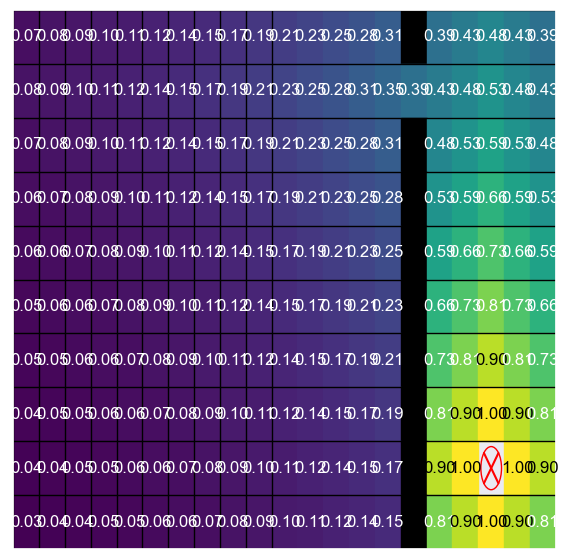

In [63]:

# Build the MDP representation
t_r_dict = env.mdp

# Parameters for policy iteration
gamma = 0.9
theta = 1e-6

# Assuming 't_r_dict' is your transition-reward dictionary from the GridWorld environment
states = list(set([s for s, _ in t_r_dict.keys()]))
actions = list(set([a for _, a in t_r_dict.keys()]))

optimal_policy, optimal_value_function = value_iteration_q(t_r_dict, states, actions)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function)

# From Q extract V
states = list(set([s for s, _ in t_r_dict.keys()]))
V = {state: 0 for state in states}
optimal_V = policy_evaluation_v(states, optimal_policy, V, t_r_dict, gamma, theta)
print("Optimal Value Function:", optimal_V)

# Grid shape and walls for visualization
grid_shape = (env.rows, env.cols)
walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# Draw the GridWorld with the optimal policy and value function
draw_simple_gridworld(
    grid_shape,
    walls,
    optimal_V,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

Optimal Policy: {(6, 18): <Action.DOWN: 2>, (4, 0): <Action.UP: 0>, (7, 17): <Action.RIGHT: 1>, (4, 9): <Action.UP: 0>, (5, 1): <Action.UP: 0>, (8, 0): <Action.UP: 0>, (3, 13): <Action.UP: 0>, (5, 10): <Action.UP: 0>, (8, 9): <Action.UP: 0>, (9, 8): <Action.UP: 0>, (0, 5): <Action.RIGHT: 1>, (2, 2): <Action.UP: 0>, (5, 19): <Action.DOWN: 2>, (9, 17): <Action.UP: 0>, (0, 14): <Action.DOWN: 2>, (2, 11): <Action.UP: 0>, (6, 2): <Action.UP: 0>, (7, 1): <Action.UP: 0>, (1, 15): <Action.RIGHT: 1>, (6, 11): <Action.UP: 0>, (7, 10): <Action.UP: 0>, (6, 20): <Action.DOWN: 2>, (4, 2): <Action.UP: 0>, (7, 19): <Action.DOWN: 2>, (3, 6): <Action.UP: 0>, (5, 3): <Action.UP: 0>, (8, 2): <Action.UP: 0>, (9, 1): <Action.UP: 0>, (5, 12): <Action.UP: 0>, (8, 11): <Action.UP: 0>, (9, 10): <Action.UP: 0>, (0, 7): <Action.RIGHT: 1>, (2, 4): <Action.UP: 0>, (9, 19): <Action.UP: 0>, (0, 16): <Action.RIGHT: 1>, (1, 8): <Action.RIGHT: 1>, (6, 4): <Action.UP: 0>, (7, 3): <Action.UP: 0>, (1, 17): <Action.RIGHT: 1

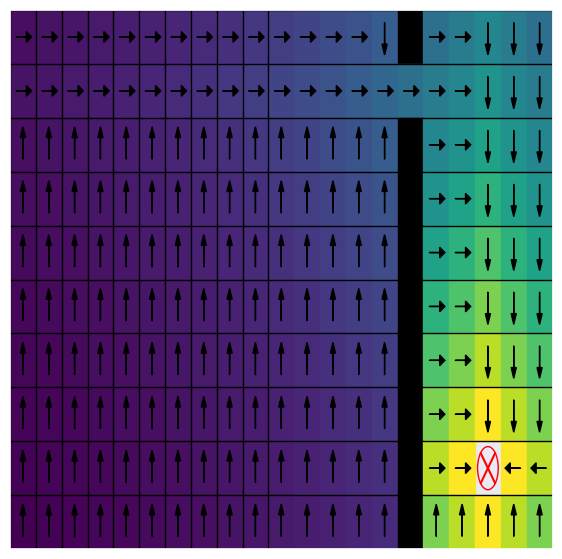

In [58]:
draw_simple_gridworld(
    grid_shape,
    walls,
    optimal_V,
    env.terminal_states,
    policy=optimal_policy,
    enable_heatmap=True,
)

### Now get the Q maps for the models in our experiments:

In [59]:
def find_matching_paths(root_dir):
    """
    Finds all matching paths under the given root directory using os.scandir.

    Parameters:
    - root_dir: The root directory to start searching from.

    Returns:
    - A list of matching paths.
    """
    matching_paths = []

    def recursive_scan(dir_path):
        with os.scandir(dir_path) as entries:
            for entry in entries:
                if entry.is_dir():
                    if len(os.path.relpath(entry.path, root_dir).split(os.sep)) == 2:
                        matching_paths.append(entry.path)
                    recursive_scan(entry.path)

    recursive_scan(root_dir)
    return matching_paths

def read_yaml_files(paths):
    """
    Reads the post_config.yaml file from each directory in the given list of paths.

    Parameters:
    - paths: List of directories to search for post_config.yaml.

    Returns:
    - A dictionary where keys are the directory paths and values are the contents of post_config.yaml.
    """
    config_data = {}

    for path in paths:
        yaml_file = os.path.join(path, "post_cfg.yaml")
        if os.path.exists(yaml_file):
            with open(yaml_file, "r") as file:
                config_data[path] = yaml.safe_load(file)
        else:
            print(f"post_config.yaml not found in {path}")

    return config_data


def flatten_stats(stats_dict):
    """
    Flattens the nested episode frames statistics in the given dictionary.

    Parameters:
    - stats_dict: The dictionary containing the statistics.

    Returns:
    - A flattened dictionary containing the episode frames statistics.
    """
    flattened = {}
    for key, value in stats_dict["episode_frames"].items():
        flattened[f"episode_frames_{key}"] = value
    return flattened

def read_yaml_files(paths):
    """
    Reads the post_config.yaml file from each directory in the given list of paths.

    Parameters:
    - paths: List of directories to search for post_config.yaml.

    Returns:
    - A dictionary where keys are the directory paths and values are the contents of post_config.yaml.
    """
    config_data = {}

    for path in paths:
        yaml_file = os.path.join(path, "post_cfg.yaml")
        if os.path.exists(yaml_file):
            with open(yaml_file, "r") as file:
                config_data[path] = yaml.safe_load(file)
        else:
            print(f"post_config.yaml not found in {path}")

    return config_data


def flatten_stats(stats_dict):
    """
    Flattens the nested episode frames statistics in the given dictionary.

    Parameters:
    - stats_dict: The dictionary containing the statistics.

    Returns:
    - A flattened dictionary containing the episode frames statistics.
    """
    flattened = {}
    for key, value in stats_dict["episode_frames"].items():
        flattened[f"episode_frames_{key}"] = value
    return flattened

# Example usage
root_dir = (
    r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jul05-115126_configs"
)
matching_paths = find_matching_paths(root_dir)
config_data = read_yaml_files(matching_paths)

In [76]:
def filter_keys_by_lr_eps(d, target_lr, target_eps, hidden_size):
    filtered_keys = {k: v for k, v in d.items() if f"optim.args_.lr_{target_lr}" in k 
                     and f"optim.args_.eps_{target_eps}" in k
                     and f"agent_params.args_.hidden_size_{hidden_size}" in k}
    return filtered_keys

filtered_dict = filter_keys_by_lr_eps(config_data, "0.001", "1e-06", 128)
len(filtered_dict.keys()) 


20

In [77]:

logger = logging.getLogger(__name__)

key = next(iter(filtered_dict))
config = filtered_dict[key]
agent = setup_dqn_agent(
        config=config,
        logger=logger,
        resume_training_path=key,
    )

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))
q_table_model = agent.compute_q_table(states, actions)
q_table_model

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.rows to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rows` for environment variables or `env.get_wrapper_attr('rows')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.cols to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cols` for environment variables or `env.get_wrapper_attr('cols')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mdp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mdp` for environment vari

{(6, 18): {<Action.UP: 0>: -6.893392,
  <Action.RIGHT: 1>: 6.149613,
  <Action.DOWN: 2>: -9.178338,
  <Action.LEFT: 3>: -11.770002},
 (4, 0): {<Action.UP: 0>: 0.0220678,
  <Action.RIGHT: 1>: 0.046331637,
  <Action.DOWN: 2>: 0.08136804,
  <Action.LEFT: 3>: 0.0491191},
 (7, 17): {<Action.UP: 0>: -6.290755,
  <Action.RIGHT: 1>: 6.2975707,
  <Action.DOWN: 2>: -8.388021,
  <Action.LEFT: 3>: -11.336622},
 (4, 9): {<Action.UP: 0>: -2.839157,
  <Action.RIGHT: 1>: 3.4763987,
  <Action.DOWN: 2>: -3.8585794,
  <Action.LEFT: 3>: -5.339012},
 (5, 1): {<Action.UP: 0>: 0.9434133,
  <Action.RIGHT: 1>: 1.3168447,
  <Action.DOWN: 2>: 1.0325665,
  <Action.LEFT: 3>: 0.61531043},
 (8, 0): {<Action.UP: 0>: -0.075761184,
  <Action.RIGHT: 1>: 0.0050700605,
  <Action.DOWN: 2>: 0.09159386,
  <Action.LEFT: 3>: -0.01549907},
 (3, 13): {<Action.UP: 0>: -4.9372325,
  <Action.RIGHT: 1>: 3.9321673,
  <Action.DOWN: 2>: -6.518984,
  <Action.LEFT: 3>: -7.746402},
 (5, 10): {<Action.UP: 0>: -3.246751,
  <Action.RIGHT: 1>

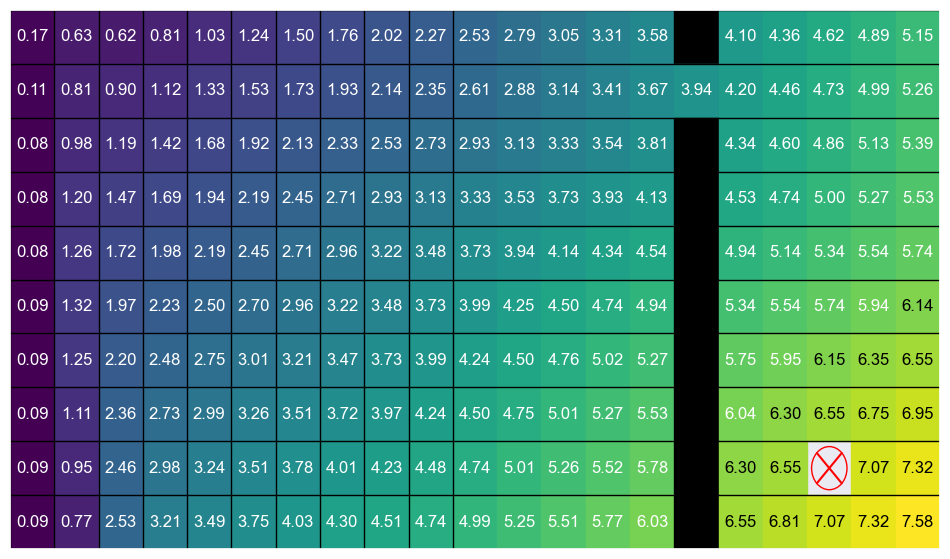

In [81]:
model_policy = derive_policy_from_q_table(q_table_model, states, actions)
V_model = extract_V_from_Q(q_table_model, states)

# Grid shape and walls for visualization
grid_shape = (env.rows, env.cols)
walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# Draw the GridWorld with the optimal policy and value function
draw_simple_gridworld(
    grid_shape,
    walls,
    V_model,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
    figsize=(12, 7)
)

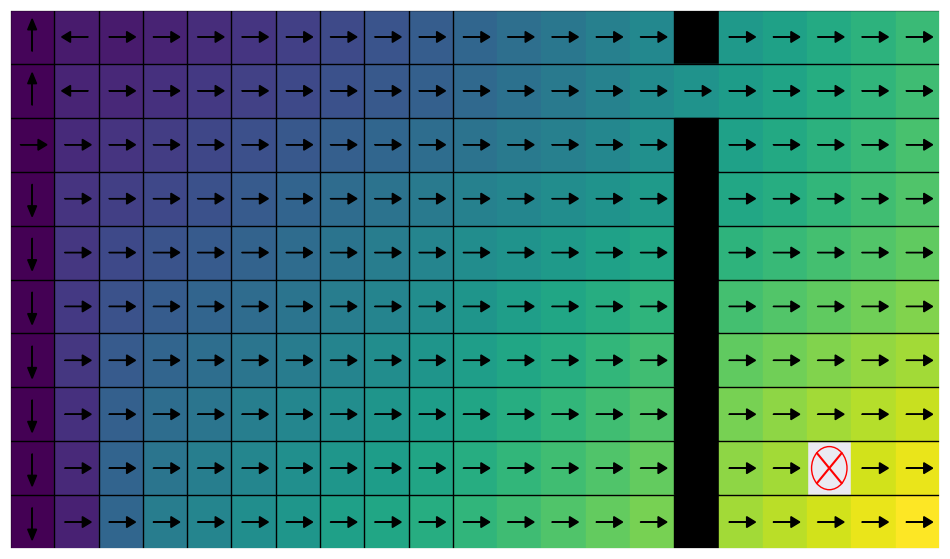

In [82]:
draw_simple_gridworld(
    grid_shape,
    walls,
    V_model,
    env.terminal_states,
    policy=model_policy,
    enable_heatmap=True,
    figsize=(12, 7)
)